## USER ENGAGEMENT ANALYSIS

#### Module Imports


In [3]:
import pickle
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, normalize
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import sys, os

In [5]:

df_telco = pd.read_csv("../data/cleaned_tellco_data.csv")
df_telco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150002 entries, 0 to 150001
Data columns (total 54 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Unnamed: 0                      150002 non-null  int64  
 1   bearer_id                       150002 non-null  float64
 2   start                           150002 non-null  object 
 3   start_ms                        150002 non-null  float64
 4   end                             150002 non-null  object 
 5   end_ms                          150002 non-null  float64
 6   dur_ms                          150002 non-null  float64
 7   imsi                            150002 non-null  float64
 8   msisdn_number                   150002 non-null  float64
 9   imei                            150002 non-null  float64
 10  last_location_name              150002 non-null  object 
 11  avg_rtt_dl_ms                   150002 non-null  float64
 12  avg_rtt_ul_ms   

In [6]:
df_telco["total_data_volume_bytes"] = df_telco["total_ul_bytes"] + df_telco["total_dl_bytes"]
df_telco_user_engagement_df = df_telco[['msisdn_number', 'bearer_id', 'dur_ms', 'total_data_volume_bytes']]

In [7]:
df_telco_user_engagement_df = df_telco_user_engagement_df.groupby(
    'msisdn_number').agg({'bearer_id': 'count', 'dur_ms': 'sum', 'total_data_volume_bytes': 'sum'})
df_telco_user_engagement_df = df_telco_user_engagement_df.rename(
    columns={'bearer_id': 'xDR Sessions'})
df_telco_user_engagement_df.head()



xDR Sessions       dur_ms  total_data_volume_bytes
msisdn_number                                                    
3.360167e+10            359  34112130.25             1.829512e+11
3.360171e+10              1     38503.00             3.396170e+08
3.360171e+10              1     52478.00             9.006109e+08
3.360171e+10              2    120298.00             1.587337e+09
3.360171e+10              1    176022.00             1.783307e+08

#### Top 10 Customers per xDR sessions


In [8]:
df_telco_user_engagement_df.nlargest(10, 'xDR Sessions')

xDR Sessions        dur_ms  total_data_volume_bytes
msisdn_number                                                     
3.373458e+10          24384  2.433842e+09             1.202521e+13
3.360167e+10            359  3.411213e+07             1.829512e+11
3.362632e+10             18  4.004556e+06             7.971167e+09
3.361489e+10             17  3.897534e+06             8.846226e+09
3.362578e+10             17  4.135208e+06             8.499621e+09
3.365973e+10             16  3.490576e+06             7.705863e+09
3.367588e+10             15  3.330228e+06             7.891111e+09
3.366716e+10             13  3.111820e+06             5.618394e+09
3.360313e+10             12  2.853343e+06             4.976195e+09
3.360452e+10             12  2.778130e+06             5.487855e+09

#### Top 10 Customers Per Duration(ms)


In [9]:
df_telco_user_engagement_df.nlargest(10, 'dur_ms')

xDR Sessions        dur_ms  total_data_volume_bytes
msisdn_number                                                     
3.373458e+10          24384  2.433842e+09             1.202521e+13
3.360167e+10            359  3.411213e+07             1.829512e+11
3.362578e+10             17  4.135208e+06             8.499621e+09
3.362632e+10             18  4.004556e+06             7.971167e+09
3.361489e+10             17  3.897534e+06             8.846226e+09
3.365973e+10             16  3.490576e+06             7.705863e+09
3.367588e+10             15  3.330228e+06             7.891111e+09
3.366716e+10             13  3.111820e+06             5.618394e+09
3.360313e+10             12  2.853343e+06             4.976195e+09
3.362708e+10             12  2.780438e+06             5.754731e+09

#### Top 10 Customers Per Total Data Traffic

In [10]:
df_telco_user_engagement_df.nlargest(10, 'total_data_volume_bytes')

xDR Sessions        dur_ms  total_data_volume_bytes
msisdn_number                                                     
3.373458e+10          24384  2.433842e+09             1.202521e+13
3.360167e+10            359  3.411213e+07             1.829512e+11
3.361489e+10             17  3.897534e+06             8.846226e+09
3.362578e+10             17  4.135208e+06             8.499621e+09
3.362632e+10             18  4.004556e+06             7.971167e+09
3.367588e+10             15  3.330228e+06             7.891111e+09
3.365973e+10             16  3.490576e+06             7.705863e+09
3.366646e+10             11  2.595291e+06             7.308501e+09
3.366471e+10             11  2.602172e+06             6.872347e+09
3.369879e+10             11  2.637400e+06             6.540899e+09

#### Handling Outliers

In [55]:

#Creating instance of our util class
# df_util = Util(df_telco_user_engagement_df)


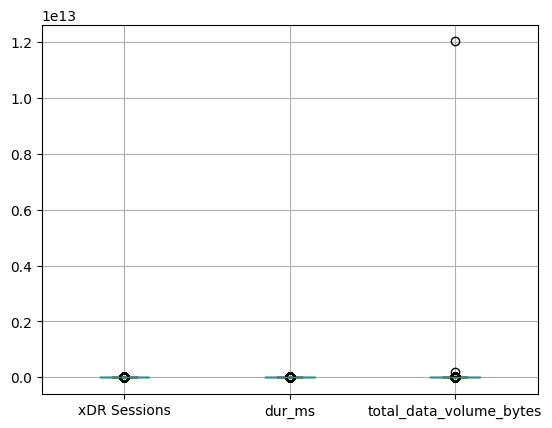

In [12]:
df_telco_user_engagement_df.boxplot();

In [11]:


def count_outliers(df, Q1, Q3, IQR, columns):
    cut_off = IQR * 1.5
    temp_df = (df[columns] < (Q1 - cut_off)) | (df[columns] > (Q3 + cut_off))
    return [len(temp_df[temp_df[col] == True]) for col in temp_df]

def calc_skew(df, columns=None):
    if columns == None:
        columns = df.columns
    return [df[col].skew() for col in columns]

def percentage(list):
    return [str(round(((value/150001) * 100), 2)) + '%' for value in list]

def getOverview(df,columns) -> None:
        min = df[columns].min()
        Q1 = df[columns].quantile(0.25)
        median = df[columns].quantile(0.5)
        Q3 = df[columns].quantile(0.75)
        max = df[columns].max()
        IQR = Q3 - Q1
        skew = calc_skew(df, columns)
        outliers = count_outliers(df, Q1, Q3, IQR, columns)
        cut_off = IQR * 1.5
        lower, upper = Q1 - cut_off, Q3 + cut_off

        new_columns = [
            'Name of columns',
            'Min',
            'Q1',
            'Median',
            'Q3',
            'Max',
            'IQR',
            'Lower fence',
            'Upper fence',
            'Skew',
            'Number_of_outliers',
            'Percentage_of_outliers' ]
        data = zip(
            [column for column in df[columns]],
            min,
            Q1,
            median,
            Q3,
            max,
            IQR,
            lower,
            upper,
            skew,
            outliers,
            percentage(outliers)
        )
        new_df = pd.DataFrame(data=data, columns=new_columns)
        new_df.set_index('Name of columns', inplace=True)
        return new_df.sort_values('Number_of_outliers', ascending=False).transpose()


getOverview(df_telco_user_engagement_df, ['xDR Sessions', 'dur_ms', 'total_data_volume_bytes'])



Name of columns                    dur_ms total_data_volume_bytes xDR Sessions
Min                                7146.0              33249009.0          1.0
Q1                                70070.0             358555880.0          1.0
Median                           102074.0             618348989.5          1.0
Q3                               172799.0            856993600.25          2.0
Max                     2433841619.370693   12025207231718.742188      24384.0
IQR                              102729.0            498437720.25          1.0
Lower fence                      -84023.5          -389100700.375         -0.5
Upper fence                      326892.5          1604650180.625          3.5
Skew                            299.85993              299.893905   299.923712
Number_of_outliers                   5699                    4413         2685
Percentage_of_outliers               3.8%                   2.94%        1.79%

In [12]:
def replace_outliers_with_fences(df, columns):
    for col in columns:
        Q1, Q3 = df[col].quantile(0.25), df[col].quantile(0.75)
        IQR = Q3 - Q1
        cut_off = IQR * 1.5
        lower, upper = Q1 - cut_off, Q3 + cut_off

        df[col] = np.where(df[col] > upper, upper, df[col])
        df[col] = np.where(df[col] < lower, lower, df[col])

replace_outliers_with_fences(df_telco_user_engagement_df, ['xDR Sessions', 'dur_ms', 'total_data_volume_bytes'])

In [13]:
getOverview(df_telco_user_engagement_df, ['xDR Sessions', 'dur_ms', 'total_data_volume_bytes'])

Name of columns        xDR Sessions    dur_ms total_data_volume_bytes
Min                             1.0    7146.0              33249009.0
Q1                              1.0   70070.0             358555880.0
Median                          1.0  102074.0             618348989.5
Q3                              2.0  172799.0            856993600.25
Max                             3.5  326892.5          1604650180.625
IQR                             1.0  102729.0            498437720.25
Lower fence                    -0.5  -84023.5          -389100700.375
Upper fence                     3.5  326892.5          1604650180.625
Skew                       1.794478  0.839186                0.759746
Number_of_outliers                0         0                       0
Percentage_of_outliers         0.0%      0.0%                    0.0%

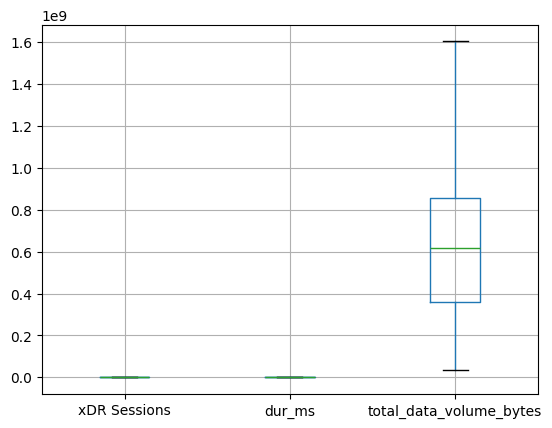

In [14]:
df_telco_user_engagement_df.boxplot();

### K-means Clustering

#### Scaling Data

In [15]:
scaler_instance = StandardScaler()
scaled_data = scaler_instance.fit_transform(df_telco_user_engagement_df)
scaled_data

array([[ 3.28881741,  2.32020199,  2.38118731],
       [-0.54939094, -1.05245656, -0.81904575],
       [-0.54939094, -0.88902168,  0.60013557],
       ...,
       [-0.54939094, -0.73035828, -0.46121225],
       [-0.54939094,  1.00239059, -0.67956342],
       [ 3.28881741,  2.32020199,  2.38118731]])

#### Normalize Data

In [16]:
normalized_data = normalize(scaled_data)
normalized_data

array([[ 0.70326378,  0.49614004,  0.50918083],
       [-0.38090376, -0.72968924, -0.56786084],
       [-0.45587466, -0.7376941 ,  0.49798164],
       ...,
       [-0.5366696 , -0.71344658, -0.45053271],
       [-0.41313151,  0.75377862, -0.51101874],
       [ 0.70326378,  0.49614004,  0.50918083]])

In [17]:
kmeans = KMeans(n_clusters=3, random_state=1).fit(normalized_data)
kmeans.labels_

/home/babi/anaconda3/envs/tenx_week1/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


array([1, 0, 0, ..., 0, 2, 1], dtype=int32)

In [18]:
df_telco_user_engagement_df.insert(0, 'cluster', kmeans.labels_)
df_telco_user_engagement_df

cluster  xDR Sessions    dur_ms  total_data_volume_bytes
msisdn_number                                                          
3.360167e+10         1           3.5  326892.5             1.604650e+09
3.360171e+10         0           1.0   38503.0             3.396170e+08
3.360171e+10         0           1.0   52478.0             9.006109e+08
3.360171e+10         1           2.0  120298.0             1.587337e+09
3.360171e+10         2           1.0  176022.0             1.783307e+08
...                ...           ...       ...                      ...
3.370000e+10         2           1.0  171672.0             8.274129e+08
3.370000e+10         0           1.0    9498.0             5.844009e+08
3.370000e+10         0           1.0   66045.0             4.810664e+08
3.370000e+10         2           1.0  214209.0             3.947535e+08
3.373458e+10         1           3.5  326892.5             1.604650e+09

[90038 rows x 4 columns]

In [19]:
df_telco_user_engagement_df['cluster'].value_counts()

0    45224
1    24189
2    20625
Name: cluster, dtype: int64

In [20]:
import plotly.io as pio
pio.renderers.default = "notebook"
fig = px.scatter(df_telco_user_engagement_df, x='total_data_volume_bytes', y='dur_ms',
                 color='cluster', size='xDR Sessions')
fig.show()

In [22]:
sns.pairplot(
    df_telco_user_engagement_df[['cluster','xDR Sessions', 'dur_ms', 'total_data_volume_bytes']],
     hue = 'cluster', diag_kind = 'kde',
             plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'},
             height=4
);

AttributeError: module 'seaborn' has no attribute 'show'

In [35]:
cluster0 = df_telco_user_engagement_df[df_telco_user_engagement_df["cluster"]==0]
cluster0[['xDR Sessions', 'dur_ms', 'total_data_volume_bytes']].describe()
#Statistical information for cluster0

xDR Sessions         dur_ms  total_data_volume_bytes
count  45224.000000   45224.000000             4.522400e+04
mean       1.005948   66342.125531             5.004959e+08
std        0.076896   31431.564573             2.432972e+08
min        1.000000    7146.000000             3.324901e+07
25%        1.000000   34449.750000             2.920080e+08
50%        1.000000   83470.000000             5.036988e+08
75%        1.000000   86400.000000             7.106121e+08
max        2.000000  124696.000000             9.492921e+08

In [36]:
cluster1 = df_telco_user_engagement_df[df_telco_user_engagement_df["cluster"]==1]
cluster1[['xDR Sessions', 'dur_ms', 'total_data_volume_bytes']].describe()
#Statistical information for cluster1

xDR Sessions         dur_ms  total_data_volume_bytes
count  24189.000000   24189.000000             2.418900e+04
mean       2.320290  208019.229950             1.116580e+09
std        0.548605   94689.490364             3.724623e+08
min        2.000000   21519.000000             1.418381e+08
25%        2.000000  129327.000000             8.369414e+08
50%        2.000000  199059.000000             1.119316e+09
75%        3.000000  316824.000000             1.467363e+09
max        3.500000  326892.500000             1.604650e+09

In [37]:
cluster2 = df_telco_user_engagement_df[df_telco_user_engagement_df["cluster"]==2]
cluster2[['xDR Sessions', 'dur_ms', 'total_data_volume_bytes']].describe()
#Statistical information for cluster2

xDR Sessions         dur_ms  total_data_volume_bytes
count  20625.000000   20625.000000             2.062500e+04
mean       1.000679  171516.916885             4.890238e+08
std        0.026045   38724.214812             2.453615e+08
min        1.000000  114579.000000             3.357584e+07
25%        1.000000  140722.000000             2.762715e+08
50%        1.000000  162198.000000             4.854153e+08
75%        1.000000  189749.000000             7.019904e+08
max        2.000000  326892.500000             9.507607e+08

#### Total Traffic of Each Application Per User

In [38]:
df_telco["social_media"] = df_telco["social_media_dl_bytes"] + df_telco['social_media_ul_bytes']
df_telco["google"] = df_telco["google_dl_bytes"] + df_telco["google_ul_bytes"]
df_telco['email'] = df_telco["email_dl_bytes"] + df_telco["email_ul_bytes"]
df_telco['youtube'] = df_telco["youtube_dl_bytes"] + df_telco["youtube_ul_bytes"]
df_telco['netflix'] = df_telco["netflix_dl_bytes"] + df_telco["netflix_ul_bytes"]
df_telco["gaming"] = df_telco["gaming_dl_bytes"] + df_telco["gaming_ul_bytes"]
df_telco['other'] = df_telco["other_dl_bytes"]+ df_telco["other_ul_bytes"]


df_telco_user_app_engagement_df = df_telco[['msisdn_number', 'social_media', 'google',
    'email', 'youtube', 'netflix',
    'gaming', 'other']]

In [39]:
df_telco_user_app_engagement_df = df_telco_user_app_engagement_df.groupby(
    'msisdn_number').sum()
df_telco_user_app_engagement_df.head()
# aggregating user engagement metrics per user

social_media        google        email       youtube  \
msisdn_number                                                          
3.360167e+10    665487661.0  2.833355e+09  818423801.0  7.948124e+09   
3.360171e+10       602474.0  1.344705e+07    2835412.0  2.541454e+07   
3.360171e+10      3036290.0  4.379917e+06    3596083.0  1.651515e+07   
3.360171e+10      4208402.0  2.115202e+07    3285166.0  6.737252e+07   
3.360171e+10      2489630.0  1.309218e+07    3264827.0  2.297488e+07   

                    netflix        gaming         other  
msisdn_number                                            
3.360167e+10   8.047787e+09  1.597187e+11  1.588765e+11  
3.360171e+10   1.247894e+07  2.830953e+08  7.861759e+08  
3.360171e+10   1.695188e+07  8.397950e+08  6.824854e+08  
3.360171e+10   5.976138e+07  1.423399e+09  1.326389e+09  
3.360171e+10   2.487300e+07  1.102870e+08  8.259411e+07

##### Top 10 Engaged Users Per App

In [41]:
youtube = df_telco_user_app_engagement_df.nlargest(10, "youtube")['youtube']
netflix = df_telco_user_app_engagement_df.nlargest(10, "netflix")['netflix']
gaming = df_telco_user_app_engagement_df.nlargest(10, "gaming")['gaming']
email = df_telco_user_app_engagement_df.nlargest(10, "email")['email']
google = df_telco_user_app_engagement_df.nlargest(10, "google")['google']
social_media = df_telco_user_app_engagement_df.nlargest(10, "social_media")['social_media']
other = df_telco_user_app_engagement_df.nlargest(10, "other")['other']

#### Optimized Value of k for User Engagement k-means Clustering

In [42]:
    
def choose_kmeans(df: pd.DataFrame, num: int):
    #Distortion is the average of the euclidean squared distance from the centroid of their respective clusters.
    # Inertia is the sum of squared distances of samples to their closest cluster centre.
    distortions = []
    inertias = []
    K = range(1, num)
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=0).fit(df)
        distortions.append(sum(
            np.min(cdist(df, kmeans.cluster_centers_, 'euclidean'), axis=1)) / df.shape[0])
        inertias.append(kmeans.inertia_)

    return (distortions, inertias)

distortions, inertias =  choose_kmeans(normalized_data, 20)

/home/babi/anaconda3/envs/tenx_week1/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/home/babi/anaconda3/envs/tenx_week1/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/home/babi/anaconda3/envs/tenx_week1/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/home/babi/anaconda3/envs/tenx_week1/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/home/babi/anaconda3

In [43]:
fig = make_subplots(
    rows=1, cols=2, subplot_titles=("Distortion", "Inertia")
)
fig.add_trace(go.Scatter(x=np.array(range(1, 20)), y=distortions), row=1, col=1)
fig.add_trace(go.Scatter(x=np.array(range(1, 20)), y=inertias), row=1, col=2)
fig.update_layout(title_text="The Elbow Method", height=500)
fig.show()

In [44]:
kmeans = KMeans(n_clusters=6, random_state=6).fit(normalized_data)
kmeans.labels_
#Using the elbow method it is suggested that k=6 is an optimal number of cluster

/home/babi/anaconda3/envs/tenx_week1/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



array([0, 3, 1, ..., 3, 5, 0], dtype=int32)

In [45]:
df_telco_user_engagement_df["cluster"]= kmeans.labels_
df_telco_user_engagement_df

cluster  xDR Sessions    dur_ms  total_data_volume_bytes
msisdn_number                                                          
3.360167e+10         0           3.5  326892.5             1.604650e+09
3.360171e+10         3           1.0   38503.0             3.396170e+08
3.360171e+10         1           1.0   52478.0             9.006109e+08
3.360171e+10         2           2.0  120298.0             1.587337e+09
3.360171e+10         5           1.0  176022.0             1.783307e+08
...                ...           ...       ...                      ...
3.370000e+10         4           1.0  171672.0             8.274129e+08
3.370000e+10         1           1.0    9498.0             5.844009e+08
3.370000e+10         3           1.0   66045.0             4.810664e+08
3.370000e+10         5           1.0  214209.0             3.947535e+08
3.373458e+10         0           3.5  326892.5             1.604650e+09

[90038 rows x 4 columns]

In [46]:
fig = px.scatter(df_telco_user_engagement_df, x='total_data_volume_bytes', y='dur_ms',
                 color='cluster', size='xDR Sessions')
fig.show()

In [47]:
df_telco_user_engagement_df.to_csv('../data/tellco_user_engagement_data.csv')
#Saving the dataframe

In [49]:
with open("../models/tellco_user_engagement.pkl", "wb") as f:
    pickle.dump(kmeans, f)
#Saveing the clustering model